In [396]:
import math
import numpy as np
from graphviz import Digraph
from activation_functions import activations as act
global exp

In [397]:
exp = math.e

In [398]:
#GraphViz functionality
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f}" % (n.label,n.data,n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

In [399]:
class Value():
    def __init__(self,data,_children=(),_op='',label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        
    def __repr__(self):
        return f"Value({self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
            
        out._backward = _backward
        return out
    
    def __mul__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data,(self,other),'*')
        
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __sub__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + (-other.data),(self,other),'-')
        return out
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def __pow__(self,other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data**other.data, (self,), f'**{other.data}')

        def _backward():
            self.grad += (other * self.data**(other-1)) * out.grad
        out._backward = _backward
        
        return out
    
    def tanh(self):
        #e^2x -1/e^2x + 1
        top = exp**(2*self.data) - 1
        bot = exp**(2*self.data) + 1
        tanh = top/bot
        out = Value(tanh,(self,),'tanh')
        
        def _backward():
            self.grad += (1-tanh**2) * out.grad
        
        out._backward = _backward
        return out
    
    def relu(self):
        out = Value(0 if self.data < 0 else self.data, (self,), 'ReLU')
            
        def _backward():
            self.grad += (out.grad > 0) * out.grad
            
        out._backward = _backward
        return out
    
    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        # go one variable at a time and apply the chain rule to get its gradient
        self.grad = 1
        for v in reversed(topo):
            v._backward()

### The basic neural network can be represented as
## $$ \hat{y} = \sum(w_i.x_i) + bias$$
#### Where
#### x is the input feature
#### w is the respective weight for the input feature
#### b is the added bias
#### tanh is the activation function to add non linearity

In [400]:
x1 = Value(2.0,label='x1')
x2 = Value(3.0,label='x2')
w1 = Value(10.0,label='w1')
w2 = Value(-9.1999999999,label='w2')
b = Value(6.881313,label='b')

In [401]:
w1x1 = w1 * x1
w1x1.label = 'w1*x1'

In [402]:
w2x2 = w2 * x2
w2x2.label = 'w2*x2'

In [403]:
wsum = w1x1 + w2x2
wsum.label = 'sum'

In [404]:
pre = wsum + b
pre.label = 'bias'

In [405]:
y_hat = pre.tanh()
y_hat.label = 'yhat'

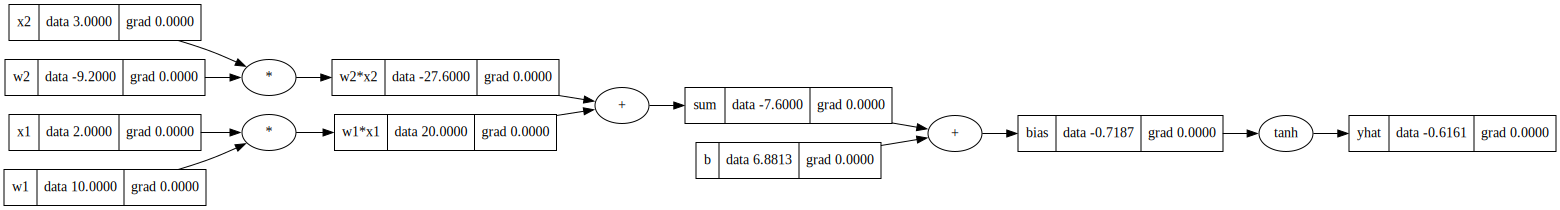

In [406]:
draw_dot(y_hat)

In [407]:
y_hat.backward()

In [408]:
class Neuron:
    def __init__(self,nin):
        self.w = [Value(np.random.uniform(-1,1)) for _ in range(nin)]
        self.b = Value(np.random.uniform(-1,1))
        
    def __call__(self,x):
        # w*x + b
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b)
        out = act.tanh()
        return out

class Layer:
    def __init__(self,nin,nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

class MLP:
    def __init__(self,nin,nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i],sz[i+1]) for i in range(len(nouts))]
    
    def __call__(self,x):
        for layer in self.layers:
            x = layer(x)
        return x

In [409]:
x = [2.0,3.0,10.0]
n = MLP(3,[4,4,1])
n(x)

Value(-0.189247641003056)

In [410]:
xs=[
    [2.0,3.0,-1.0],
    [3.0,3.0,4.0],
    [4.0,2.0,1.5],
    [5.5,3.5,2.5]
]
ys = [1.0,-1.0,-1.0,1.0]

In [411]:
ypred = [n(x) for x in xs]

In [412]:
ypred

[Value(-0.7992534531276019),
 Value(-0.196930435718331),
 Value(-0.22037614995896956),
 Value(-0.20664906250625192)]

In [413]:
for ygt,yout in zip(ys,ypred):
    print(ygt)
    print(yout)

1.0
Value(-0.7992534531276019)
-1.0
Value(-0.196930435718331)
-1.0
Value(-0.22037614995896956)
1.0
Value(-0.20664906250625192)


In [415]:
loss = sum((yout-ygt)**2 for ygt,yout in zip(ys,ypred))

TypeError: unsupported operand type(s) for +: 'int' and 'Value'

In [ ]:
draw_dot(loss)

In [417]:
for ygt,yout in zip(ys,ypred):
    print(ygt)
    print(yout)

1.0
Value(-0.7992534531276019)
-1.0
Value(-0.196930435718331)
-1.0
Value(-0.22037614995896956)
1.0
Value(-0.20664906250625192)
